#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 특성 세트

 **학습 목표:** 복잡한 특성 세트만큼 좋은 성능을 발휘하는 최소한의 특성 세트를 만듭니다.

 지금까지는 모델에 모든 특성을 집어넣었습니다. 그러나 모델에 포함된 특성이 적을수록 리소스 사용이 감소하며 유지보수도 쉬워집니다. 이제부터는 주택 관련 특성을 최소한으로 사용하면서 데이터 세트의 모든 특성을 사용하는 모델과 동등한 성능을 발휘하는 모델을 만들 수 있는지를 살펴보겠습니다.

 ## 설정

이전과 마찬가지로 캘리포니아 주택 데이터를 로드하고 준비하겠습니다.

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

TensorFlow 1.x selected.


In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2651.0,540.8,1434.0,502.6,3.9,2.0
std,2.1,2.0,12.6,2180.8,421.5,1140.2,384.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1460.8,296.0,788.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2132.5,435.0,1172.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3159.2,651.0,1727.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2626.1,536.0,1419.1,498.0,3.9,2.0
std,2.1,2.0,12.6,2177.9,421.4,1166.0,385.9,1.9,1.0
min,32.5,-124.3,1.0,11.0,3.0,11.0,3.0,0.5,0.3
25%,33.9,-121.8,18.0,1464.8,298.0,793.0,282.0,2.5,1.5
50%,34.2,-118.5,29.0,2116.0,431.5,1156.0,407.0,3.5,2.0
75%,37.7,-118.0,37.0,3135.2,644.0,1705.2,601.0,4.7,2.3
max,41.9,-114.5,52.0,32627.0,6445.0,28566.0,6082.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,207.9
std,116.2
min,15.0
25%,120.3
50%,180.5
75%,265.4
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.8
std,115.4
min,15.0
25%,117.8
50%,179.9
75%,264.4
max,500.0


 ## 작업 1: 효율적인 특성 세트 개발

**특성을 2~3개만 사용하면서 성능을 어디까지 올릴 수 있을까요?**

**상관행렬**은 각 특성을 타겟과 비교한 결과 및 각 특성을 서로 비교한 결과에 따라 쌍의 상관성을 보여줍니다.

여기에서는 상관성을 [피어슨 상관계수](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)로 정의합니다.  이 실습을 위해 자세한 수학적 원리를 이해할 필요는 없습니다.

상관성 값의 의미는 다음과 같습니다.

  * `-1.0`: 완벽한 음의 상관성
  * `0.0`: 상관성 없음
  * `1.0`: 완벽한 양의 상관성

In [ ]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.1
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.1,-0.0,0.1,0.7,0.2,1.0


 타겟과 상관성이 높은 특성을 찾아야 합니다.

또한 각 특성이 서로 독립적인 정보를 추가하도록 서로간의 상관성이 높지 않은 특성을 찾는 것이 좋습니다.

이 정보를 참고하여 특성을 삭제해 보세요. 두 가지 원시 특성의 비율과 같은 합성 특성을 추가로 만들어 볼 수도 있습니다.

편의를 위해 이전 실습의 학습 코드를 포함해 두었습니다.

In [4]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [6]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    coordinates):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.figure()
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  _ = plt.plot()

  validation_predictions = pd.DataFrame({'median_house_value': pd.Series(validation_predictions).apply(lambda x: min(x, 500.001))})
  print(validation_targets.describe())
  print(validation_predictions.describe())

  # Output a plot
  plt.figure()
  plt.ylabel('target')
  plt.xlabel('prediction')
  plt.title('target vs prediction Plot')
  plt.scatter(validation_predictions['median_house_value'], validation_targets['median_house_value'])
  _ = plt.plot()

    # 지도
  plt.figure(figsize=(13, 8))

  ax = plt.subplot(1, 2, 1)
  ax.set_title("Validation Data")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(coordinates["longitude"],
              coordinates["latitude"],
              cmap="coolwarm",
              c=validation_predictions['median_house_value']/validation_targets['median_house_value'].max())

  ax = plt.subplot(1,2,2)
  ax.set_title("Targets")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(coordinates["longitude"],
              coordinates["latitude"],
              cmap="coolwarm",
              c=validation_targets['median_house_value']/validation_targets['median_house_value'].max())
  _ = plt.plot()

  return linear_regressor

 5분 동안 효율적인 특성 세트 및 학습 매개변수를 찾아보세요. 그런 다음 해결 방법을 확인하여 모범 답안을 알아보세요. 특성마다 필요한 학습 매개변수가 다를 수 있다는 점에 유의하시기 바랍니다.

Training model...
RMSE (on training data):
  period 00 : 214.69
  period 01 : 191.63
  period 02 : 169.26
  period 03 : 147.92
  period 04 : 128.07
  period 05 : 110.51
  period 06 : 96.62
  period 07 : 89.58
  period 08 : 87.26
  period 09 : 86.07
Model training finished.
       median_house_value
count              5000.0
mean                205.8
std                 115.4
min                  15.0
25%                 117.8
50%                 179.9
75%                 264.4
max                 500.0
       median_house_value
count              5000.0
mean                195.3
std                  77.9
min                  51.1
25%                 140.1
50%                 181.9
75%                 234.9
max                 500.0


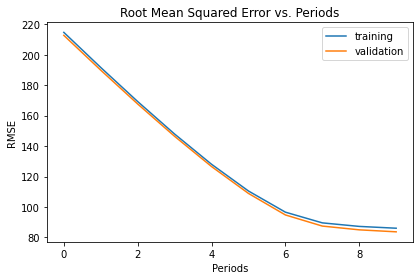

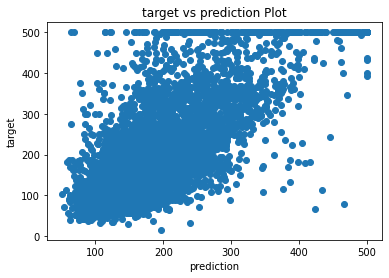

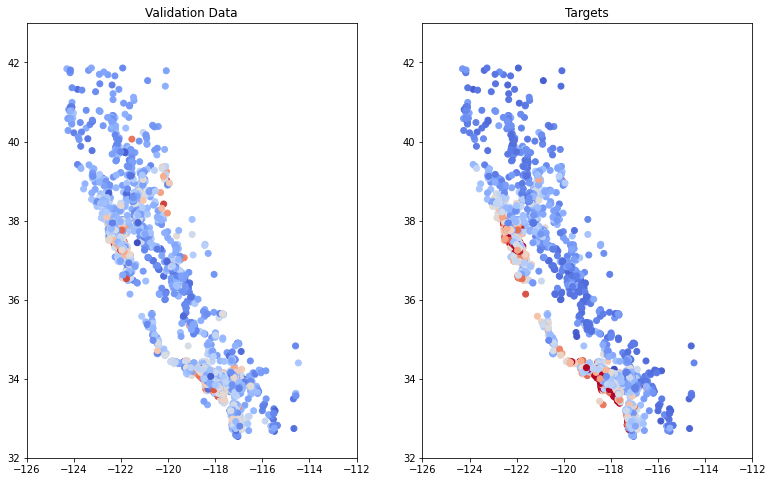

In [9]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = ['median_income', 'rooms_per_person']

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
linear_regressor = train_model(
    learning_rate=0.03,
    steps=350,
    batch_size=10,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets,
    coordinates = validation_examples[['latitude', 'longitude']])

<generator object Estimator.predict at 0x7f94567b1780>
85.53
       median_house_value
count              3000.0
mean                193.3
std                  76.7
min                  32.3
25%                 139.1
50%                 182.0
75%                 230.8
max                 500.0
       median_house_value
count              3000.0
mean                205.8
std                 113.1
min                  22.5
25%                 121.2
50%                 177.6
75%                 264.0
max                 500.0


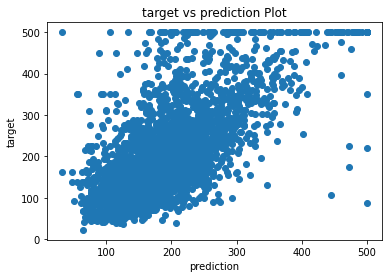

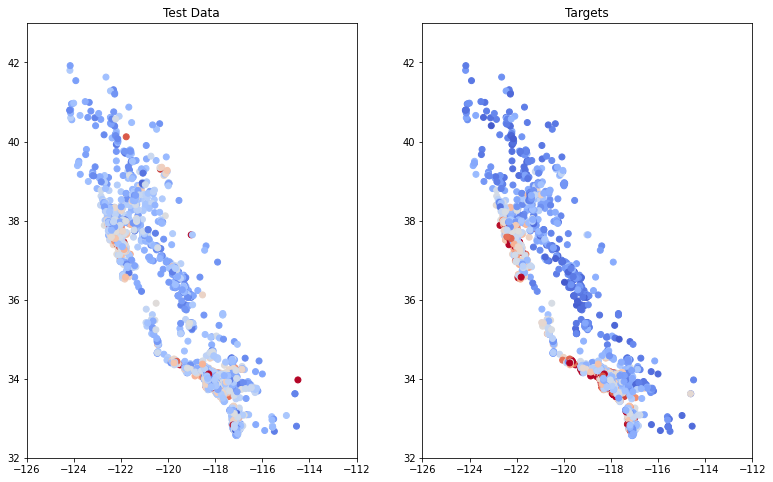

In [10]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
california_housing_test_data = california_housing_test_data.reindex(
    np.random.permutation(california_housing_test_data.index))
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

minimal_features = ['median_income', 'rooms_per_person']

assert minimal_features, "You must select at least one feature!"

minimal_test_examples = test_examples[minimal_features]

predict_test_input_fn = lambda: my_input_fn(
  minimal_test_examples, 
  test_targets['median_house_value'],
  num_epochs=1,
  shuffle=False
)

predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
print(predictions)
predictions = np.array([item['predictions'][0] for item in predictions])

# Compute loss.
root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(predictions, test_targets))
# Occasionally print the current loss.
print("%0.2f" % (root_mean_squared_error))

predictions = pd.DataFrame({'median_house_value': pd.Series(predictions).apply(lambda x: min(x, 500.001))})

plt.figure()
plt.ylabel('target')
plt.xlabel('prediction')
plt.title('target vs prediction Plot')
plt.scatter(predictions['median_house_value'], test_targets['median_house_value'])
_ = plt.plot()

print(predictions.describe())
print(test_targets.describe())

# 지도
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Test Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=predictions['median_house_value']/test_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title("Targets")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=test_targets['median_house_value']/test_targets['median_house_value'].max())
_ = plt.plot()

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

Training model...
RMSE (on training data):
  period 00 : 164.51
  period 01 : 121.18
  period 02 : 116.17
  period 03 : 115.57
  period 04 : 114.99
  period 05 : 114.62
  period 06 : 113.68
  period 07 : 114.18
  period 08 : 113.12
  period 09 : 112.54
Model training finished.
       median_house_value
count              5000.0
mean                209.0
std                 118.0
min                  15.0
25%                 118.8
50%                 180.4
75%                 267.4
max                 500.0
       median_house_value
count              5000.0
mean                199.4
std                  12.9
min                 171.6
25%                 188.6
50%                 197.9
75%                 209.8
max                 253.6


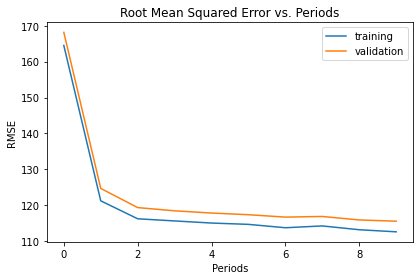

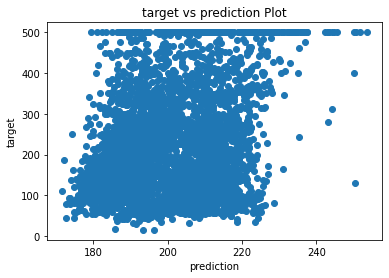

In [ ]:
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ## 작업 2: 위도 활용 고도화

`latitude`와 `median_house_value`로 그래프를 그리면 선형 관계가 없다는 점이 드러납니다.

대신, 로스앤젤레스 및 샌프란시스코에 해당하는 위치 부근에 마루가 나타납니다.

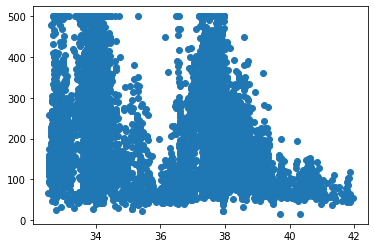

In [ ]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [ ]:
training_examples

 **위도를 더 잘 활용할 수 있는 합성 특성을 만들어 보세요.**

예를 들어 `latitude`를 `|latitude - 38|`의 값에 매핑하는 특성을 만들고 이름을 `distance_from_san_francisco`로 지정할 수 있습니다.

또는 공간을 10개의 버킷으로 나눌 수 있습니다. `latitude_32_to_33`, `latitude_33_to_34` 등의 특성을 만들고 `latitude`가 해당 버킷의 범위에 포함되면 `1.0` 값을, 그렇지 않으면 `0.0` 값을 표시하면 됩니다.

상관행렬을 개발에 참고하면서 적절한 특성이 발견되면 모델에 추가하세요.

검증 성능을 최대 어느 정도까지 높일 수 있나요?

In [ ]:
correlation_dataframe["distance_from_sanfrancisco"] = abs(correlation_dataframe['latitude'] - 38)
correlation_dataframe["distance_from_losangeles"] = abs(correlation_dataframe['latitude'] - 34)
correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target,distance_from_sanfrancisco,distance_from_losangeles
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.1,-0.9,1.0
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.1,0.9,-0.9
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1,-0.1,-0.0
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1,0.0,-0.0
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0,0.1,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.3,0.7,0.0,-0.1
rooms_per_person,0.2,-0.1,-0.1,0.1,0.1,-0.2,-0.0,0.3,1.0,0.3,-0.1,0.2
target,-0.1,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,0.3,1.0,0.0,-0.2
distance_from_sanfrancisco,-0.9,0.9,-0.1,0.0,0.1,0.1,0.1,0.0,-0.1,0.0,1.0,-0.8


 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

 `latitude` 이외에 `median_income`도 유지하여 이전 결과와 비교하겠습니다.

위도를 버킷화하기로 결정했습니다. Pandas에서 `Series.apply`를 사용하면 되므로 매우 간단합니다.

In [ ]:
LATITUDE_RANGES = zip(range(32, 41), range(33, 42))
for r in LATITUDE_RANGES:
  print(r)

(32, 33)
(33, 34)
(34, 35)
(35, 36)
(36, 37)
(37, 38)
(38, 39)
(39, 40)
(40, 41)


In [12]:
LATITUDE_RANGES = zip(range(36, 39), range(37, 40))

def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  # selected_examples = source_df[["median_income", "rooms_per_person"]].copy()
  selected_examples["median_income"] = source_df["median_income"]
  selected_examples["rooms_per_person"] = source_df["rooms_per_person"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)
selected_validation_examples["latitude_36_to_37"] = validation_examples["latitude"].apply(
      lambda l: 1.0 if l >= 36 and l < 37 else 0.0)
selected_validation_examples["latitude_37_to_38"] = validation_examples["latitude"].apply(
      lambda l: 1.0 if l >= 37 and l < 38 else 0.0)
selected_validation_examples["latitude_38_to_39"] = validation_examples["latitude"].apply(
      lambda l: 1.0 if l >= 38 and l < 39 else 0.0)
selected_validation_examples

,median_income,rooms_per_person,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39
9366,3.3,1.1,0.0,0.0,0.0
12488,2.5,1.9,0.0,0.0,0.0
2328,1.6,1.8,0.0,0.0,0.0
13088,4.2,2.3,1.0,0.0,0.0
11443,5.7,2.0,0.0,0.0,1.0
...,...,...,...,...,...
16833,2.7,2.1,0.0,0.0,0.0
15633,1.8,1.6,0.0,1.0,0.0
9193,4.6,2.2,0.0,0.0,0.0
495,1.4,2.4,0.0,0.0,0.0


In [ ]:
correlation_dataframe = selected_training_examples.copy()
correlation_dataframe['target'] = training_targets['median_house_value']
correlation_dataframe.corr()

,median_income,rooms_per_person,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,target
median_income,1.0,0.3,-0.0,0.1,0.0,-0.1,-0.1,0.1,-0.1,-0.1,-0.1,0.7
rooms_per_person,0.3,1.0,-0.0,-0.1,-0.1,-0.0,-0.0,0.0,0.1,0.1,0.1,0.3
latitude_32_to_33,-0.0,-0.0,1.0,-0.1,-0.2,-0.0,-0.1,-0.1,-0.1,-0.0,-0.0,-0.1
latitude_33_to_34,0.1,-0.1,-0.1,1.0,-0.3,-0.1,-0.1,-0.3,-0.2,-0.1,-0.1,0.1
latitude_34_to_35,0.0,-0.1,-0.2,-0.3,1.0,-0.1,-0.1,-0.3,-0.2,-0.1,-0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
latitude_37_to_38,0.1,0.0,-0.1,-0.3,-0.3,-0.1,-0.1,1.0,-0.2,-0.1,-0.1,0.2
latitude_38_to_39,-0.1,0.1,-0.1,-0.2,-0.2,-0.1,-0.1,-0.2,1.0,-0.1,-0.0,-0.2
latitude_39_to_40,-0.1,0.1,-0.0,-0.1,-0.1,-0.0,-0.0,-0.1,-0.1,1.0,-0.0,-0.1
latitude_40_to_41,-0.1,0.1,-0.0,-0.1,-0.1,-0.0,-0.0,-0.1,-0.0,-0.0,1.0,-0.1


Training model...
RMSE (on training data):
  period 00 : 211.28
  period 01 : 185.07
  period 02 : 160.82
  period 03 : 137.07
  period 04 : 115.88
  period 05 : 99.42
  period 06 : 89.24
  period 07 : 85.94
  period 08 : 85.47
  period 09 : 85.44
Model training finished.
       median_house_value
count              5000.0
mean                205.8
std                 115.4
min                  15.0
25%                 117.8
50%                 179.9
75%                 264.4
max                 500.0
       median_house_value
count              5000.0
mean                202.9
std                  80.4
min                  56.1
25%                 145.7
50%                 189.1
75%                 243.9
max                 500.0


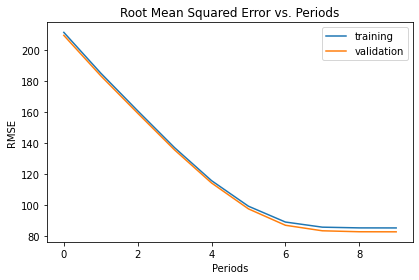

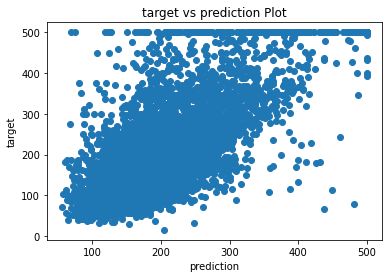

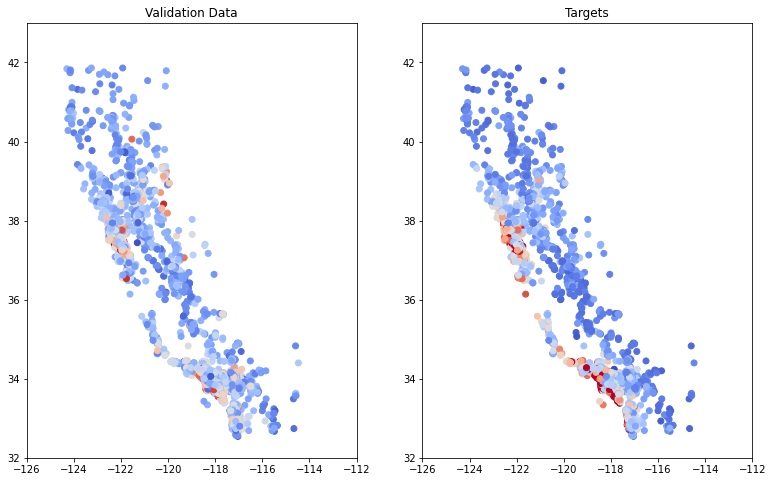

In [16]:

linear_regressor = train_model(
    learning_rate=0.03,
    steps=400,
    batch_size=10,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets,
    coordinates = validation_examples[['latitude', 'longitude']]
    )

<generator object Estimator.predict at 0x7f9458f87fc0>
84.77
       median_house_value
count              3000.0
mean                200.8
std                  79.1
min                  33.6
25%                 144.7
50%                 189.1
75%                 239.4
max                 500.0
       median_house_value
count              3000.0
mean                205.8
std                 113.1
min                  22.5
25%                 121.2
50%                 177.6
75%                 264.0
max                 500.0


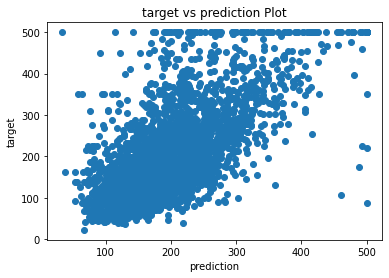

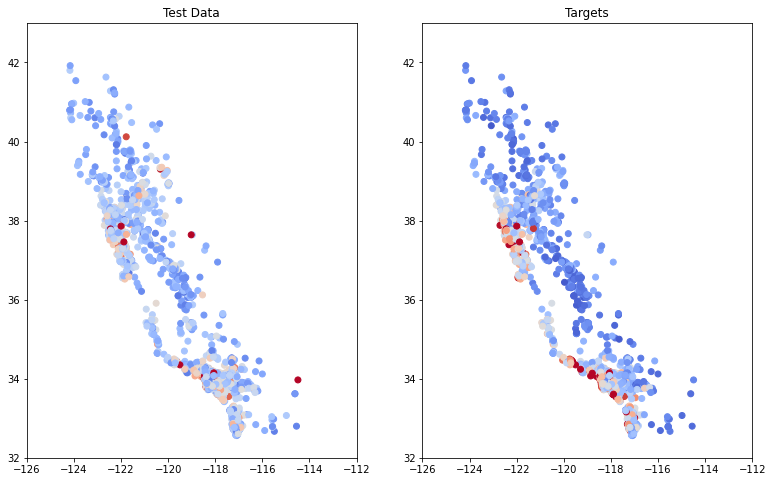

In [23]:
# california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
# california_housing_test_data = california_housing_test_data.reindex(
#     np.random.permutation(california_housing_test_data.index))
# test_examples = preprocess_features(california_housing_test_data)
# test_targets = preprocess_targets(california_housing_test_data)

# minimal_features = ['median_income', 'rooms_per_person']

# assert minimal_features, "You must select at least one feature!"

# minimal_test_examples = test_examples[minimal_features]
minimal_test_examples = select_and_transform_features(test_examples)
minimal_test_examples["latitude_36_to_37"] = test_examples["latitude"].apply(
      lambda l: 1.0 if l >= 36 and l < 37 else 0.0)
minimal_test_examples["latitude_37_to_38"] = test_examples["latitude"].apply(
      lambda l: 1.0 if l >= 37 and l < 38 else 0.0)
minimal_test_examples["latitude_38_to_39"] = test_examples["latitude"].apply(
      lambda l: 1.0 if l >= 38 and l < 39 else 0.0)

predict_test_input_fn = lambda: my_input_fn(
  minimal_test_examples, 
  test_targets['median_house_value'],
  num_epochs=1,
  shuffle=False
)

predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
print(predictions)
predictions = np.array([item['predictions'][0] for item in predictions])

# Compute loss.
root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(predictions, test_targets))
# Occasionally print the current loss.
print("%0.2f" % (root_mean_squared_error))

predictions = pd.DataFrame({'median_house_value': pd.Series(predictions).apply(lambda x: min(x, 500.001))})

plt.figure()
plt.ylabel('target')
plt.xlabel('prediction')
plt.title('target vs prediction Plot')
plt.scatter(predictions['median_house_value'], test_targets['median_house_value'])
_ = plt.plot()

print(predictions.describe())
print(test_targets.describe())

# 지도
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Test Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=predictions['median_house_value']/test_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title("Targets")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=test_targets['median_house_value']/test_targets['median_house_value'].max())
_ = plt.plot()